<a href="https://colab.research.google.com/github/cherry247/Data-Science/blob/master/Zindi_vacccinate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
from pathlib import Path
from fastai.text import *

In [ ]:
train=pd.read_csv("/content/Train (1).csv")
test=pd.read_csv("/content/Test (1).csv")

In [ ]:
train.tail()

,tweet_id,safe_text,label,agreement
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000
10000,P6190L3Q,Pneumonia vaccine: for women w risk of pulmona...,1.0,0.666667


---

* The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

* label: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)

---



In [ ]:
train=train.dropna(0)#drop all the null values

In [ ]:
test=test.fillna("")
test['lable']=0

In [ ]:
df_valid=train.sample(900)
df_train=train.loc[~train.tweet_id.isin(df_valid.tweet_id.values) ]
df_train.shape ,df_valid.shape

((9099, 4), (900, 4))

FastAi stores data in databunch

In [ ]:
fast_data=TextClasDataBunch.from_df(path=Path(''),train_df=df_train,valid_df=df_valid,test_df=test,label_cols='label',text_cols='safe_text')

In [ ]:
fast_data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
"xxbos xxmaj if i xxmaj got xxmaj the xxmaj cold , xxmaj flu , xxup h1n1 , xxmaj black xxmaj death , xxmaj xxunk xxmaj virus , xxmaj measles / xxmaj mumps , xxmaj chicken xxmaj pox xxmaj then xxmaj you xxmaj got xxmaj it xxmaj to xxmaj because xxmaj you xxmaj my xxmaj xxunk xxmaj we xxmaj share xxmaj xxunk !",0.0
"xxbos [ xxmaj to roommate ] \n "" xxmaj we should go get flu vaccines . "" \n xxmaj why ? \n "" xxmaj well , the flu is n't a great a great disease . "" \n xxmaj the flu is fine . \n "" xxmaj ok . """,0.0
xxbos xxup aids n : xxmaj here 's xxmaj how xxmaj the xxup hpv xxmaj vaccine xxmaj can xxmaj help xxmaj cut xxmaj the xxmaj risk xxmaj of xxmaj cancer xxmaj in xxmaj gay xxmaj men : xxmaj many xxup hiv - positive xxunk men already … < url >,1.0
xxbos < user > xxup measles xxup outbreak xxup bc xxup ignorant xxup parents xxup refuse xxup vax xxup for xxup kids : xxup action xxup is xxup xxunk xxup for xxup cdc 2 xxup not xxup allow xxup any xxup child xxup wo xxup vac 2 xxup attend .,1.0
"xxbos xxup rt < user > xxmaj wet xxmaj xxunk : xxmaj xxunk on # xxup hpv , xxmaj immune xxmaj health , xxmaj vaccines for xxmaj xxunk ) xxmaj sex & # stis . < url > < xxmaj great xxmaj read ! xxmaj check it out .",1.0


In [ ]:
clas = text_classifier_learner(fast_data,AWD_LSTM,drop_mult=0.3, metrics=[rmse])

In [ ]:
clas.fit_one_cycle(20)

In [ ]:
preds, y = clas.get_preds(DatasetType.Test)

In [ ]:
sub = pd.DataFrame({
    'tweet_id':test['tweet_id'],
    'label':[p[0] for p in preds.numpy()]
})
sub.to_csv('first_try_fastai_20_epochs.csv', index=False)
sub.head()

,tweet_id,label
0,00BHHHP1,0.283039
1,00UNMD0E,0.301483
2,01AXPTJF,0.354942
3,01HOEQJW,0.373492
4,01JUKMAO,0.259139


In [ ]:
#let us train a language model and then we will train the classifier
data_lm=TextLMDataBunch.from_df(path='',train_df=df_train,valid_df=df_valid,text_cols='safe_text')

In [ ]:
learner=language_model_learner(data_lm,AWD_LSTM,drop_mult=0.5)

In [ ]:
learner.fit_one_cycle(2,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.741589,3.720194,0.324888,00:09
1,3.940463,3.590425,0.340737,00:09


In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.411143,3.356165,0.371466,00:11
1,3.229326,3.273733,0.386533,00:12
2,3.029550,3.250547,0.389509,00:12


In [ ]:
learner.save_encoder('ft_enc')

In [ ]:
learn=text_classifier_learner(fast_data,AWD_LSTM,drop_mult=0.5,metrics=[rmse])

In [ ]:
learn.load_encoder('ft_enc')

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 2.51E-02


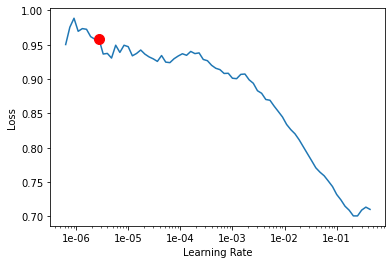

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2,1e-2)
learn.freeze_to(-2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.419286,0.338538,0.578437,00:05
1,0.379644,0.335326,0.575262,00:05


In [ ]:
learn.fit_one_cycle(4,slice(5e-3/2,5e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.369107,0.340370,0.580051,00:06
1,0.357553,0.328136,0.569415,00:05
2,0.321041,0.332207,0.572735,00:06
3,0.276053,0.339756,0.579387,00:06


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.277180,0.343611,0.581712,00:13
1,0.267713,0.342131,0.578761,00:12
2,0.234069,0.329893,0.567963,00:12
3,0.202462,0.341608,0.578312,00:12
4,0.190534,0.342062,0.578434,00:12


In [ ]:
preds, y = learn.get_preds(DatasetType.Test)
sub = pd.DataFrame({
    'tweet_id':test['tweet_id'],
    'label':[p[0] for p in preds.numpy()]
})
sub.to_csv('fastai_2nd_try_lm.csv', index=False)
sub.head()

,tweet_id,label
0,00BHHHP1,-0.545833
1,00UNMD0E,0.306153
2,01AXPTJF,0.230983
3,01HOEQJW,1.177470
4,01JUKMAO,0.359048


lets move to second approach to this problem.

In [ ]:
l=[]
for i in train['agreement']:
  if i>=1.0:
      l.append(1)
  elif i>0.5:
      l.append(2)
  else:
    l.append(3)

In [ ]:
train['agreement']=l

In [ ]:
l=[]
for i in train['label']:
    if i>0:
        l.append(2)    # 1.0--------> 2
    elif i==0:
        l.append(1)     # 0.0 ---------> 1
    else:
        l.append(0)    #-1.0  --------> 0

In [ ]:
train['label']=l

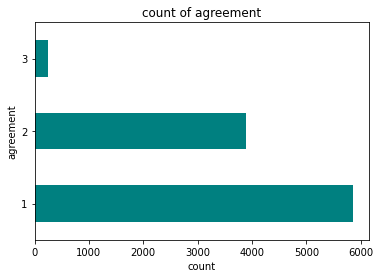

In [ ]:
train['agreement'].value_counts().plot(kind='barh',color='teal')
plt.title("count of agreement")
plt.xlabel("count")
plt.ylabel("agreement")
plt.show()

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
data = dict(
    number=train['label'].value_counts(),
    stage=["positive","neutral","negative"])
fig = px.funnel(data, x='number', y='stage')
fig.show()

In [ ]:
train['safe_text']=train['safe_text'].str.replace('https?://[A-Za-z0-9./]+',' ')

In [ ]:
test['safe_text']=test['safe_text'].str.replace('https?://[A-Za-z0-9./]+',' ')

In [ ]:
train['safe_text']=train['safe_text'].str.replace("[^a-zA-Z]"," ")

In [ ]:
test['safe_text']=test['safe_text'].str.replace("[^a-zA-Z]"," ")

In [ ]:
train['safe_text']

0        Me  amp  The Big Homie meanboy      MEANBOY  M...
1        I m      thinking of devoting my career to pro...
2         whatcausesautism VACCINES  DO NOT VACCINATE Y...
3        I mean if they immunize my kid with something ...
4        Thanks to  user  Catch me performing at La Nui...
                               ...                        
9996     Living in a time where the sperm I used to was...
9997      user   user   In spite of all measles outbrea...
9998     Interesting trends in child immunization in Ok...
9999     CDC Says Measles Are At Highest Levels In Deca...
10000    Pneumonia vaccine  for women w risk of pulmona...
Name: safe_text, Length: 9999, dtype: object

In [ ]:
tt_title=train['safe_text'].apply(lambda x:x.split())

In [ ]:
from nltk import PorterStemmer
stemmer = PorterStemmer() 
tt_title=tt_title.apply(lambda x:[stemmer.stem(i) for i in x])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop_words =stopwords.words('english')

In [ ]:
filter_title=[]
for i in tt_title:
    l=[]
    for j in i:
        if j not in stop_words:
            l.append(j.lower())
    filter_title.append(' '.join(l))

In [ ]:
train['safe_text']=filter_title

In [ ]:
train.drop('tweet_id',1,inplace=True)

In [ ]:
tt_title=test['safe_text'].apply(lambda x:x.split()) 
tt_title=tt_title.apply(lambda x:[stemmer.stem(i) for i in x])
filter_title=[]
for i in tt_title:
    l=[]
    for j in i:
        if j not in stop_words:
            l.append(j.lower())
    filter_title.append(' '.join(l))
test['safe_text']=filter_title
test.drop('tweet_id',1,inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=1000,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
tfidf_stem = tfidf_vectorizer.fit_transform(train['safe_text'])

In [ ]:
tfidf_stem_1 = tfidf_vectorizer.fit_transform(test['safe_text'])

In [ ]:
y=train['label']

In [ ]:
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(tfidf_stem,y,random_state=42,test_size=0.3)

In [ ]:
train.drop("label",1,inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
rf=RandomForestClassifier()
rf.fit(xtrain_bow,ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf.score(xvalid_bow,yvalid)

0.73

In [ ]:
pred=rf.predict(xvalid_bow)

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(yvalid,pred)**0.5) #our mean squared error is high 
# ideal rmse should be between 0.2 and 0.5
#lets try logistic regression

0.7218032973047436


In [ ]:
#for logistic regression we need binary label but we have three labels 
lr=LogisticRegression(solver='lbfgs')

In [ ]:
lr.fit(xtrain_bow,ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred=lr.predict(xvalid_bow)

In [ ]:
print(mean_squared_error(yvalid,pred)**0.5) #our mean squared error is not reduced sufficently 

0.7002380547594749


In [ ]:
#lets convert label into three seperate columns and try logistice regression
a=[]
b=[]
c=[]
for i in y:
    if i==2:
        a.append(1)
        b.append(0)
        c.append(0)

    elif i==1:
        b.append(1)
        c.append(0)
        a.append(0)


    else:
        c.append(1)
        a.append(0)
        b.append(0)



train['label1']=a
train['label0']=b
train['label-1']=c

In [ ]:
train.head()

,safe_text,agreement,label1,label0,label-1
0,me amp big homi meanboy meanboy mb mb mmr steg...,1,0,1,0
1,i think devot career prove autism caus vaccin ...,1,1,0,0
2,whatcausesaut vaccin do vaccin child,1,0,0,1
3,i mean immun kid someth secretli kill year lin...,1,0,0,1
4,thank user catch perform la nuit nyc st ave sh...,1,0,1,0


In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(tfidf_stem,train['label0'],random_state=42,test_size=0.3)

In [ ]:
lr=LogisticRegression()
lr.fit(xtrain,ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred=lr.predict(xvalid)
print(mean_squared_error(yvalid,pred)**0.5) #our mean squared error is not reduced sufficently

0.3301514803843836


In [ ]:
#similarly lets do for others to check whether it a good fit or not

In [ ]:
#lets go ahead with this approach and process our test set as well
pred1=lr.predict(tfidf_stem_1)

In [ ]:
pred2=lr.predict(tfidf_stem_1)

In [ ]:
pred3=lr.predict(tfidf_stem_1)

In [ ]:
test['pred1']=pred1
test['pred2']=pred2
test['pred3']=pred3


In [ ]:
label=[]
for i in range(len(pred2)):
  if pred1[i]==1:
      label.append(1.0)
  elif pred2[i]==1:
      label.append(0.0)
  elif pred3[i]==1:
      label.append(-1.0)
  else:
      label.append(-1.0)
    

In [ ]:
test['lable']=label

In [ ]:
sample=pd.read_csv('/content/SampleSubmission (1).csv')

In [ ]:
sample['label']=label

In [ ]:
sample.to_csv('lm.csv', index=False)